In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
#os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%load_ext autoreload
%autoreload 2

from i3cols_dataloader import load_events
from likelihood import LLH


import matplotlib.animation as animation

import gc

from tqdm import tqdm

import dragoman as dm
from dragoman.utils.stats import weighted_quantile

%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [3]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [4]:
tf.test.is_gpu_available()

True

# Test NNs
Using an independent MC file

In [5]:
events, labels = load_events(dir='/home/iwsatlas1/peller/work/oscNext/level7_v01.04/140000_i3cols_test',
                            recos = {'spefit': 'SPEFit2_DC',
                                    'retro' : 'retro_crs_prefit__median__neutrino'})

In [6]:
my_llh = LLH(hitnet_file='models/HitNet_08_May_2020-16h02/epoch_3625_model.hdf5',
          chargenet_file='models/ChargeNet_08_May_2020-15h59/epoch_600_model.hdf5',
         )

# Optimization
We need a massively parallel optimization scheme in order to make use of the GPU's power, i.e. evaluate O(1000) llhs at once in every iteration

In [7]:
geo = np.load('geo_array.npy')

In [16]:
def run_generation(event, params):

    # eval fitness
    total_llh, _, _, _ = my_llh(event, params)
    
    
    valid = np.isfinite(total_llh)
    n_valid = np.sum(valid)
    #print(n_valid)
    total_llh = total_llh[valid]
    opt_hist.append([np.min(total_llh), np.mean(total_llh)])
    

    
    
    pool_size = 5
    
    # create selection pool
    sorted_llh_idx = np.argsort(total_llh)[::-1]
    ranks = (np.arange(n_valid) + 1) * (np.arange(n_valid)) / 2
    rand_r = np.random.rand(pool_size * N_individuals) * np.max(ranks)    
    d = np.digitize(rand_r, ranks)
    
    selection_pool_idx = sorted_llh_idx[d].reshape(pool_size, -1)
    selection_pool = params[valid][selection_pool_idx]

    rand_r = rand_r.reshape(pool_size, -1)
    
    worst_mask = rand_r == np.min(rand_r, axis=0)
    worst_pool = selection_pool[worst_mask]
    
    # cross over
    from_mother = np.random.rand(*params.shape) < 0.5
    new_params = np.empty_like(params)
    new_params[from_mother] = selection_pool[0][from_mother]
    new_params[~from_mother] = selection_pool[1][~from_mother]

    # mutation
    
    mutate_all = get_rand_params(event, N_individuals)
    #mutate_all[4] = np.random.rand(l) * 2 * np.pi
    #mutate_all[5] = np.random.rand(l) * np.pi
    #mutate_all[:,6] = np.clip((np.random.rand(N_individuals) + np.random.rand(N_individuals)) * params[:,6], a_min=1, a_max=100)
    #mutate_all[:,7] = np.clip((np.random.rand(N_individuals) + np.random.rand(N_individuals)) * params[:,7], a_min=0, a_max=100)
    
    mutate = np.random.rand(*params.shape) < 1. / params.shape[1]
    
    new_params[mutate] = mutate_all[mutate]
    
#     rand_params = get_rand_params(N_individuals)
    
#     new_params[mutate, 0:4] = rand_params[mutate, 0:4]
    
#     new_params[mutate, 4] = np.random.rand(l) * 2 * np.pi
#     new_params[mutate, 5] = np.random.rand(l) * np.pi
#     new_params[mutate, 6] = (np.random.rand(l) + np.random.rand(l)) * new_params[mutate, 6]
#     new_params[mutate, 7] = (np.random.rand(l) + np.random.rand(l)) * new_params[mutate, 7]
    
    # do some 1-d simplex ops
#     simplex = np.random.rand(params.shape[0]) < 0.05
#     new_params[simplex, 0:4] = 2 * (np.sum(selection_pool[:, simplex, 0:4], axis=0) - worst_pool[simplex, 0:4]) / 4. - worst_pool[simplex, 0:4]

#     invalid = (new_params[:,0] < -250) | (new_params[:,0] > 250)
#     new_params[invalid, 0] = params[invalid, 0]
#     invalid = (new_params[:,1] < -250) | (new_params[:,1] > 250)
#     new_params[invalid, 1] = params[invalid, 1]
#     invalid = (new_params[:,2] < -600) | (new_params[:,2] > 0)
#     new_params[invalid, 2] = params[invalid, 2]
#     invalid = (new_params[:,3] < 9000) | (new_params[:,3] > 10000)
#     new_params[invalid, 3] = params[invalid, 3]

    # and keep best individual alive
    # actually, no....this picks up some garbage
    #new_params[0] = params[np.argmin(total_llh)]
    
    return new_params

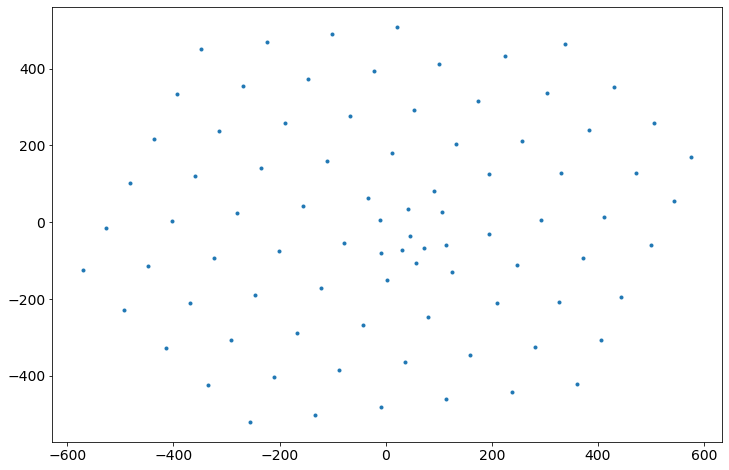

In [17]:
plt.plot(geo[:,0, 0],geo[:,0, 1],'.')

In [30]:
def get_rand_params(event, N):
    params = np.random.rand(N, len(labels),)
    
    R = 120
    r = R * np.sqrt(np.random.rand(N))
    theta = np.random.rand(N) * 2 * np.pi
    x = 46 + r * np.cos(theta)
    y = -35 + r * np.sin(theta)
    
    params[:, 0] = x
    params[:, 1] = y
    params[:, 2] = -params[:, 2] * 400 - 150
    #params[:, 3] = event['params'][3]
    params[:, 3] = (params[:, 3] - 0.5) * 1000 + 9500
    params[:, 4] *= 2*np.pi
    params[:, 5] =  np.arccos(2 * params[:, 5] - 1)
    params[:, 6] *= 100 #event['params'][6]
    params[:, 7] *= 100 #event['params'][7]

    return params

In [39]:
N_individuals = 10000
event_idx = np.random.randint(0, len(events) - 1) #6666#3939 #2458
event = events[event_idx]

for l,p in zip(labels, event['params']):
    print(f'{l.ljust(20)}{p:.1f}')
print('n_hits'.ljust(20), len(event['hits']))

x                   142.7
y                   -30.9
z                   -570.5
time                9339.1
azimuth             3.8
zenith              3.0
cascade_energy      8.8
track_energy        30.7
n_hits               17


In [40]:
params = get_rand_params(event, N_individuals)

opt_hist = []

In [41]:
N_gen = 10
with tqdm(total=N_gen) as pbar:
    for i in range(N_gen):
        params = run_generation(event, params)
        pbar.update(1)

100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


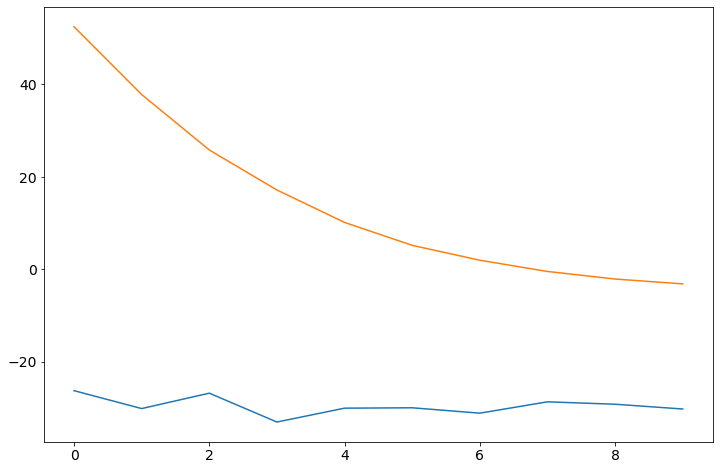

In [42]:
plt.plot(np.array(opt_hist))

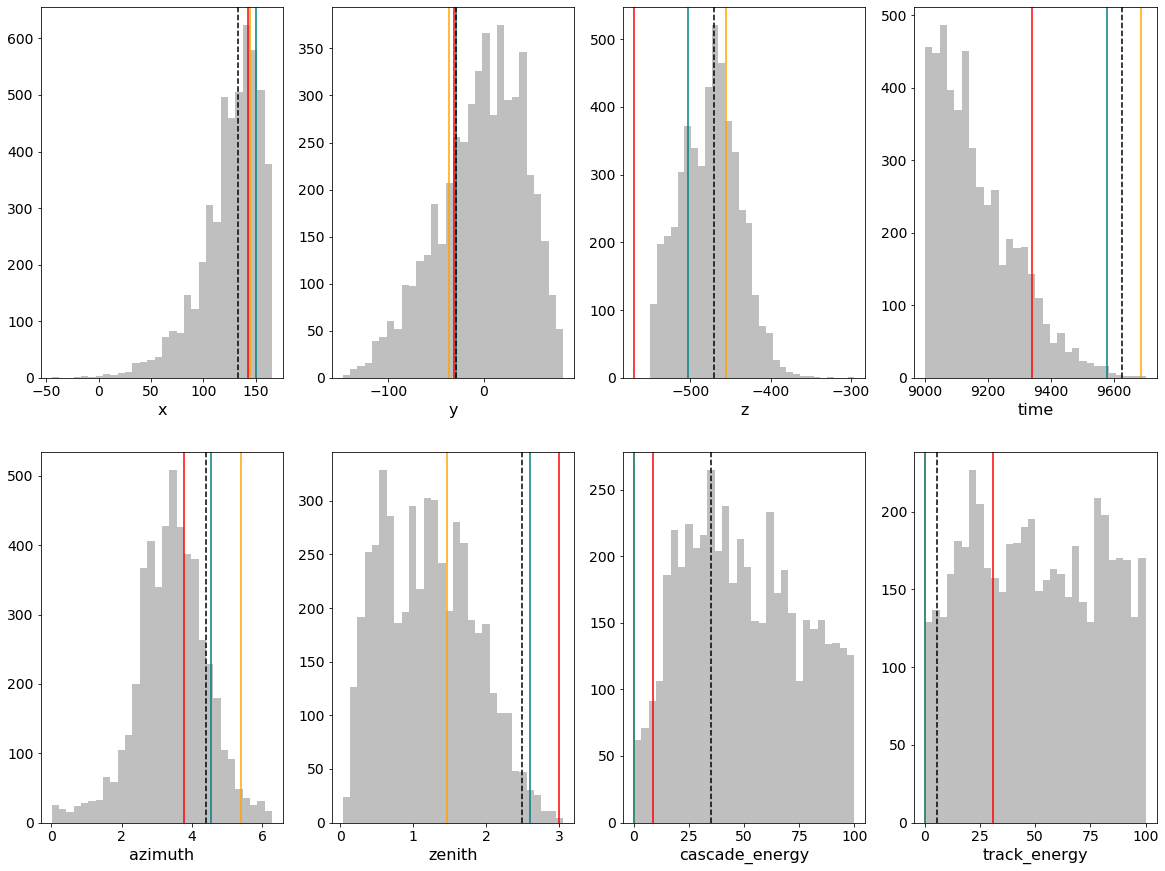

In [43]:
total_llh, _, _, _ = my_llh(event, params)
fig, ax = plt.subplots(2, 4, figsize=(20, 15))


best = params[np.argmin(total_llh)]

for i, label in enumerate(labels):
    axis = ax[i//4, i%4]
    axis.hist(params[total_llh < np.median(total_llh)][:,i], bins=30, color='gray', alpha=0.5)
    #axis.hist(params[ok_mask][:,i], weights=np.ones(np.sum(ok_mask))*1000, bins=30)
    axis.set_xlabel(label)
    axis.axvline(event['params'][i], c='r')
    axis.axvline(event['spefit'][i], c='orange')
    axis.axvline(event['retro'][i], c='teal')
    axis.axvline(best[i], c='k', ls='--')
    #axis.axvline(np.median(params[ok_mask][:,i]), c='g', ls=':')

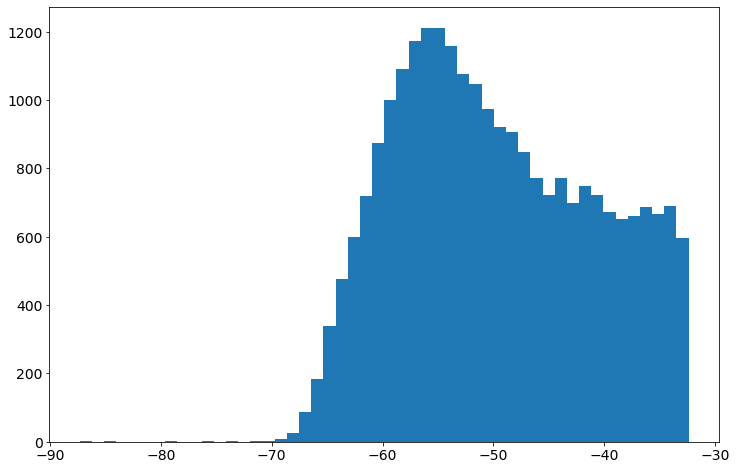

In [1452]:
plt.hist(total_llh[total_llh < np.median(total_llh)], bins=50);

In [1453]:
event['spefit']

array([nan, nan, nan, nan, nan, nan,  0.,  0.], dtype=float32)